# 2. Methods of simulation

In questa sezione descriviamo:
- le condizioni iniziali utilizzate,
- i metodi numerici di integrazione (RK4 a passo fisso e RK45 adattivo),
- le quantità diagnostiche che usiamo per valutare l’accuratezza (energia totale, errore, ecc.).


In [24]:

import numpy as np

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt


In [25]:
# 2.1 Equations of motion (3 corpi in 2D, G = 1)

def system_odes(t, s, m1, m2, m3):
    """
    Stato s = [x1,y1,x2,y2,x3,y3,vx1,vy1,vx2,vy2,vx3,vy3]
    Ritorna ds/dt = [vx1,vy1,...,ax1,ay1,...].
    """

    # Posizioni
    r1 = s[0:2]
    r2 = s[2:4]
    r3 = s[4:6]

    # Velocità
    v1 = s[6:8]
    v2 = s[8:10]
    v3 = s[10:12]

    # Accelerazioni gravitazionali (G = 1)
    dv1_dt = m3*(r3 - r1)/np.linalg.norm(r3 - r1)**3 \
           + m2*(r2 - r1)/np.linalg.norm(r2 - r1)**3

    dv2_dt = m3*(r3 - r2)/np.linalg.norm(r3 - r2)**3 \
           + m1*(r1 - r2)/np.linalg.norm(r1 - r2)**3

    dv3_dt = m1*(r1 - r3)/np.linalg.norm(r1 - r3)**3 \
           + m2*(r2 - r3)/np.linalg.norm(r2 - r3)**3

    # Derivate delle posizioni = velocità, derivate delle velocità = accelerazioni
    return np.array([
        v1[0], v1[1],
        v2[0], v2[1],
        v3[0], v3[1],
        dv1_dt[0], dv1_dt[1],
        dv2_dt[0], dv2_dt[1],
        dv3_dt[0], dv3_dt[1]
    ])


# 2.2 Metodo RK4 a passo fisso

def rk4_step(t_n, y_n, k, m1, m2, m3):
    """
    Un singolo passo di Runge–Kutta del 4° ordine.
    """
    k1 = system_odes(t_n,         y_n,            m1, m2, m3)
    k2 = system_odes(t_n + k/2.0, y_n + k*k1/2.0, m1, m2, m3)
    k3 = system_odes(t_n + k/2.0, y_n + k*k2/2.0, m1, m2, m3)
    k4 = system_odes(t_n + k,     y_n + k*k3,     m1, m2, m3)

    y_next = y_n + (k/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return y_next


def rk4_integrate(t_span, y0, k, m1, m2, m3):
    """
    Integra il sistema con RK4 a passo fisso k sull'intervallo t_span.
    Ritorna: array dei tempi t_rk4 e degli stati sol_rk4.
    """
    t0, tf = t_span
    N = int((tf - t0) / k)

    t_values = np.zeros(N+1)
    y_values = np.zeros((N+1, len(y0)))

    t_values[0] = t0
    y_values[0] = y0

    t_n = t0
    y_n = y0

    for i in range(1, N+1):
        y_n = rk4_step(t_n, y_n, k, m1, m2, m3)
        t_n = t_n + k

        t_values[i] = t_n
        y_values[i] = y_n

    return t_values, y_values


## 2.1 Methods

Teoria di RK4

In [26]:
# Solve the ODE using RK4 
def rk4(t_n, v_n, k, m1, m2, m3):
    phi1 = system_odes(t_n, v_n, m1, m2, m3)
    phi2 = system_odes(t_n + k/2.0, v_n + (k/2.0)*phi1, m1, m2, m3)
    phi3 = system_odes(t_n + k/2.0, v_n + (k/2.0)*phi2, m1, m2, m3)
    phi4 = system_odes(t_n + k, v_n + k*phi3, m1, m2, m3)

    v_next = v_n + (k/6.0)*(phi1 + 2*phi2 + 2*phi3 + phi4)
    return v_next


def rk4_integrate(t_span, v0, k, m1, m2, m3):
    t0, tf = t_span
    N = int((tf - t0) / k)

    t_values = np.zeros(N+1)
    v_values = np.zeros((N+1, len(v0)))

    t_values[0] = t0
    v_values[0] = v0

    t_n = t0
    v_n = v0

    for i in range(1, N+1):
        v_n = rk4(t_n, v_n, k, m1, m2, m3)
        t_n = t_n + k

        t_values[i] = t_n
        v_values[i] = v_n

    return t_values, v_values



Add detail about using RK45

In [27]:
# 2.4 Helper per simulare uno scenario con RK4 e RK45

def simulate_three_body(masses, pos_list, vel_list,
                        t_span=(0.0, 40.0), k=0.01, n_eval=400):
    """
    masses: (m1, m2, m3)
    pos_list: [r1, r2, r3] con r_i = np.array([x_i, y_i])
    vel_list: [v1, v2, v3] con v_i = np.array([vx_i, vy_i])
    """

    m1, m2, m3 = masses

    init_cond = np.array(pos_list + vel_list).ravel()

    # RK4 a passo fisso
    t_rk4, sol_rk4 = rk4_integrate(t_span, init_cond, k, m1, m2, m3)

    # RK45 adattivo (solve_ivp)
    t_eval = np.linspace(t_span[0], t_span[1], n_eval)
    sol = solve_ivp(system_odes, t_span, init_cond,
                    t_eval=t_eval, args=(m1, m2, m3))

    return t_rk4, sol_rk4, sol.t, sol.y


## 2.2 Other validation methods

Aggiungere descrizione teorica 

In [28]:
def total_energy(x1,y1,v1x,v1y, x2,y2,v2x,v2y, x3,y3,v3x,v3y, m1,m2,m3):
    # kinetic energy
    K  = 0.5*m1*(v1x**2 + v1y**2)
    K += 0.5*m2*(v2x**2 + v2y**2)
    K += 0.5*m3*(v3x**2 + v3y**2)
    
    # distances
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    r13 = np.sqrt((x3-x1)**2 + (y3-y1)**2)
    r23 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
    
    # potential energy (G = 1)
    U = - m1*m2/r12 - m1*m3/r13 - m2*m3/r23
    
    return K + U

## 2.3 Initial conditions

We firstly start with defining the initial conditions

### plot mass scenario 
- equal masses (already showing)
- change of mass proportions in the rotating triangle
- perturbation of velocity in the rotating triangle
- one large mass 
- solar system 


In [37]:
omega = 0.8

# 1) Equal masses – rotating triangle
# posizioni: triangolo equilatero di lato 2
pos_eq = [
    np.array([ 1.0, 0.0]),
    np.array([-0.5,  np.sqrt(3)/2]),
    np.array([-0.5, -np.sqrt(3)/2])
]

# velocità per rotazione rigida: v = ω * (-y, x)
vel_eq = [
    np.array([-0.0 * omega,  1.0 * omega]),                    # [0, ω]
    np.array([-(np.sqrt(3)/2)*omega, -0.5 * omega]),           # corpo 2
    np.array([+(np.sqrt(3)/2)*omega, -0.5 * omega])            # corpo 3
]

masses_eq = (1.0, 1.0, 1.0)

# 2) Perturbation of rotating triangle
delta_v = np.array([0.05, 0.0])  # piccola perturbazione sulla vx del corpo 1

vel_eq_pert = [
    vel_eq[0] + delta_v,   # solo il corpo 1 perturbato
    vel_eq[1],
    vel_eq[2]
]

# 3) Different mass ratio of rotating triangle

masses_eq_pert = (1.0, 2.0, 3.0)

# 4) Massive central mass
masses_star = (10.0, 1.0, 1.0)   # m1 = stella

# mettiamo la massa grande vicino all'origine,
# gli altri due un po' più lontani
pos_star = [
    np.array([0.0, 0.0]),    # stella massiva
    np.array([2.0, 0.0]),    # pianeta 2
    np.array([-2.0, 0.0])    # pianeta 3
]

# velocità approssimative per orbita (molto grossolane, non perfettamente kepleriane)
vel_star = [
    np.array([0.0, 0.1]),           # stella quasi ferma
    np.array([0.0, 1.2]),           # pianeta 2 verso l'alto
    np.array([0.0,-1.2])            # pianeta 3 verso il basso
]


# 5) Earth–Sun–Moon (scalato, 2D)
m_sun   = 1.0
m_earth = 3.0e-6
m_moon  = 3.7e-8

masses_esl = (m_sun, m_earth, m_moon)

R_se = 1.0        # distanza Sole–Terra
R_em = 0.00257    # distanza Terra–Luna

pos_esl = [
    np.array([0.0,       0.0]),        # Sole
    np.array([R_se,      0.0]),        # Terra
    np.array([R_se+R_em, 0.0])         # Luna
]

# velocità approssimative per orbite quasi circolari
v_earth = np.array([0.0, 1.0])
v_moon  = np.array([0.0, 1.1])

vel_esl = [
    np.array([0.0, 0.0]),  # Sole quasi fermo
    v_earth,
    v_moon
]

# ----------------- SCENARI -----------------

scenarios = [
    {
        "name":   "Equal masses – rotating triangle",
        "masses": masses_eq,
        "pos":    pos_eq,
        "vel":    vel_eq
    },
    {
        "name":   "Mass changed – rotating triangle",
        "masses": masses_eq_pert,
        "pos":    pos_eq,
        "vel":    vel_eq

    },
    {
        "name":   "Perturbed rotating triangle",
        "masses": masses_eq,
        "pos":    pos_eq,
        "vel":    vel_eq_pert
    },
    {
        "name":   "Massive central mass",
        "masses": masses_star,
        "pos":    pos_star,
        "vel":    vel_star
    },
    {
        "name":   "Earth–Sun–Moon",
        "masses": masses_esl,
        "pos":    pos_esl,
        "vel":    vel_esl
    }
]



Comment on initial conditions

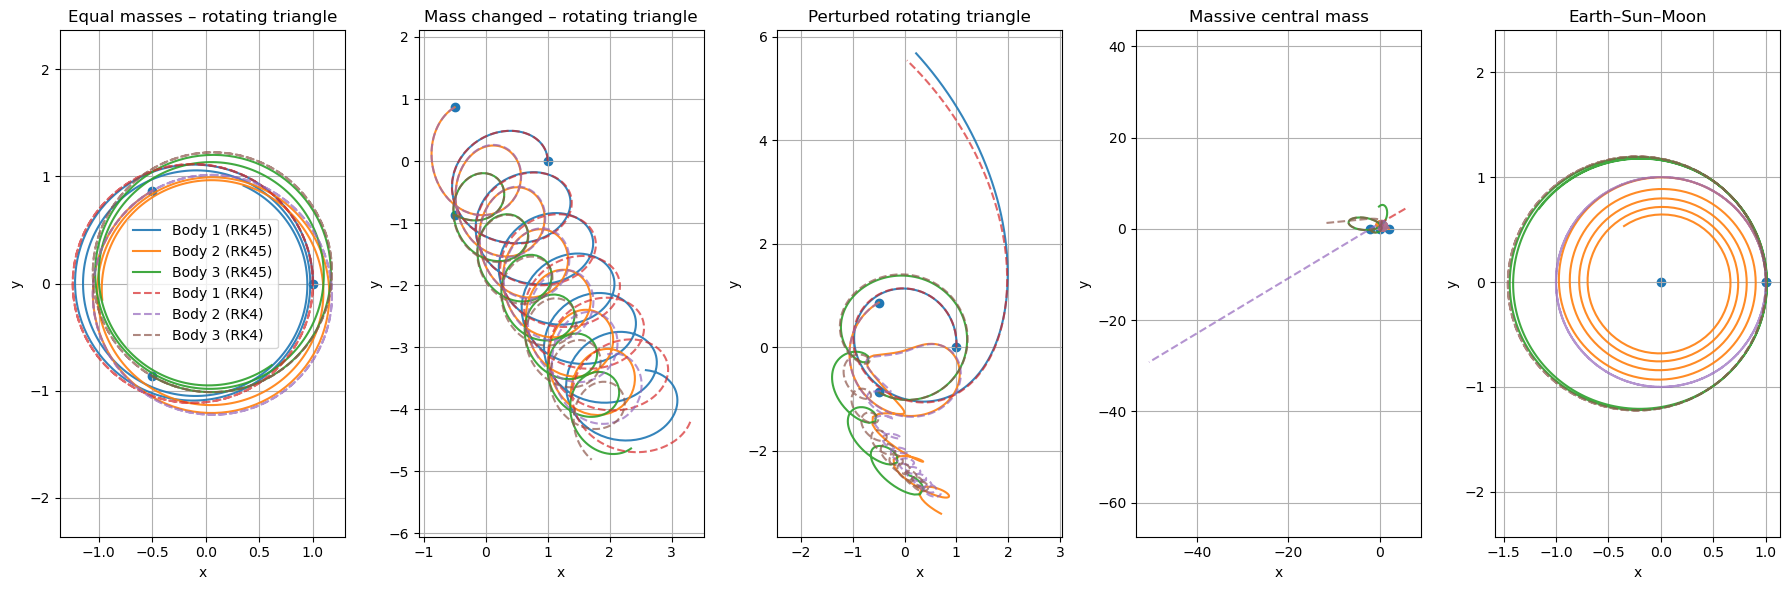

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(18, 6))

for ax, sc in zip(axes, scenarios):
    masses   = sc["masses"]
    pos_list = sc["pos"]
    vel_list = sc["vel"]

    # usa la tua simulate_three_body(masses, pos_list, vel_list, ...)
    t_rk4, sol_rk4, t_rk45, y_rk45 = simulate_three_body(
        masses, pos_list, vel_list,
        t_span=(0, 20), k=0.01, n_eval=400
    )

    # ----- RK45 (soluzione adattiva) -----
    x1_45, y1_45 = y_rk45[0], y_rk45[1]
    x2_45, y2_45 = y_rk45[2], y_rk45[3]
    x3_45, y3_45 = y_rk45[4], y_rk45[5]

    # ----- RK4 (passo fisso) -----
    x1_4, y1_4 = sol_rk4[:, 0], sol_rk4[:, 1]
    x2_4, y2_4 = sol_rk4[:, 2], sol_rk4[:, 3]
    x3_4, y3_4 = sol_rk4[:, 4], sol_rk4[:, 5]

    # RK45: linee piene
    ax.plot(x1_45, y1_45, label="Body 1 (RK45)", alpha=0.9)
    ax.plot(x2_45, y2_45, label="Body 2 (RK45)", alpha=0.9)
    ax.plot(x3_45, y3_45, label="Body 3 (RK45)", alpha=0.9)

    # RK4: linee tratteggiate
    ax.plot(x1_4, y1_4, "--", label="Body 1 (RK4)", alpha=0.7)
    ax.plot(x2_4, y2_4, "--", label="Body 2 (RK4)", alpha=0.7)
    ax.plot(x3_4, y3_4, "--", label="Body 3 (RK4)", alpha=0.7)

    # punti iniziali (da RK45)
    ax.scatter([x1_45[0], x2_45[0], x3_45[0]],
               [y1_45[0], y2_45[0], y3_45[0]],
               marker='o')

    ax.set_title(sc["name"])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axis("equal")
    ax.grid(True)

# legenda solo nel primo pannello
axes[0].legend()
plt.tight_layout()
plt.show()
